Problem Statement - You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
from scipy.stats.contingency import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [60]:
import tensorflow as tf
from keras import models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [61]:
train_df = pd.read_csv('train.csv')
train_df['is_train'] = True
test_df = pd.read_csv('test.csv')
test_df['is_train'] = False

df = pd.concat([train_df, test_df])


In [62]:
df0 = df.copy()

In [63]:
df.duplicated().sum()

np.int64(0)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  object 
 3   Name                      135000 non-null  object 
 4   Age                       150000 non-null  object 
 5   SSN                       150000 non-null  object 
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  object 
 8   Monthly_Inhand_Salary     127500 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  int64  
 10  Num_Credit_Card           150000 non-null  int64  
 11  Interest_Rate             150000 non-null  int64  
 12  Num_of_Loan               150000 non-null  object 
 13  Type_of_Loan              132888 non-null  object 

In [65]:
df = df[df['Payment_Behaviour'] != '!@9#%8']  
df[['Spending_Level', 'Payment_Value']] = df['Payment_Behaviour'].str.split('_', n=1, expand=True) 
df['Payment_Value'] = df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  
df['Payment_Value'] = df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  # Bu satır aynı kalıyor
df['Payment_Value'] = df['Payment_Value'].str.replace('spent_', '')

In [66]:
def convert_to_months(age_str):
    if pd.isna(age_str):  
        return 0
    parts = age_str.split()
    years = int(parts[0])  
    months = int(parts[3])  
    return years * 12 + months  

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_months) 

In [67]:
drop_columns = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month','Type_of_Loan', 'Payment_Behaviour']
df.drop(drop_columns, axis=1, inplace=True)

In [68]:
df.shape

(138600, 24)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138600 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       138600 non-null  object 
 1   Occupation                138600 non-null  object 
 2   Annual_Income             138600 non-null  object 
 3   Monthly_Inhand_Salary     117809 non-null  float64
 4   Num_Bank_Accounts         138600 non-null  int64  
 5   Num_Credit_Card           138600 non-null  int64  
 6   Interest_Rate             138600 non-null  int64  
 7   Num_of_Loan               138600 non-null  object 
 8   Delay_from_due_date       138600 non-null  int64  
 9   Num_of_Delayed_Payment    128968 non-null  object 
 10  Changed_Credit_Limit      138600 non-null  object 
 11  Num_Credit_Inquiries      135841 non-null  float64
 12  Credit_Mix                138600 non-null  object 
 13  Outstanding_Debt          138600 non-null  object 

In [70]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,is_train,Spending_Level,Payment_Value
0,23,Scientist,19114.12,"1,824.84",3,4,3,4,3,7,11.27,4.00,_,809.98,26.82,265,No,49.57,80.41529543900253,312.49408867943663,Good,True,High,Small
1,23,Scientist,19114.12,NaN,3,4,3,4,-1,NaN,11.27,4.00,Good,809.98,31.94,0,No,49.57,118.28022162236736,284.62916249607184,Good,True,Low,Large
2,-500,Scientist,19114.12,NaN,3,4,3,4,3,7,_,4.00,Good,809.98,28.61,267,No,49.57,81.699521264648,331.2098628537912,Good,True,Low,Medium
3,23,Scientist,19114.12,NaN,3,4,3,4,5,4,6.27,4.00,Good,809.98,31.38,268,No,49.57,199.4580743910713,223.45130972736786,Good,True,Low,Small
4,23,Scientist,19114.12,"1,824.84",3,4,3,4,6,NaN,11.27,4.00,Good,809.98,24.80,269,No,49.57,41.420153086217326,341.48923103222177,Good,True,High,Medium


In [71]:
num_cols = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card","Interest_Rate","Num_of_Loan", "Delay_from_due_date","Num_of_Delayed_Payment","Changed_Credit_Limit", "Num_Credit_Inquiries","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly",	"Monthly_Balance","Credit_History_Age"] 
cat_cols = ["Occupation","Credit_Mix", "Spending_Level","Payment_Value","Payment_of_Min_Amount"]  
target_col = ["Credit_Score"]

In [72]:
class DataCleaner:
    def __init__(self, dataframe, numeric_columns):
        self.dataframe = dataframe
        self.numeric_columns = numeric_columns

    def clean_numeric_columns(self):
        
        for col in self.numeric_columns:
            
            if self.dataframe[col].dtype == 'object': 
                self.dataframe[col] = self.dataframe[col].str.extract(r'(\d+)')
                self.dataframe[col] = pd.to_numeric(self.dataframe[col], errors='coerce')
                self.dataframe[col] = self.dataframe[col].fillna(self.dataframe[col].median())
            
            else:
                self.dataframe[col] = self.dataframe[col].fillna(self.dataframe[col].median())
       
        return self.dataframe

cleaner = DataCleaner(df, num_cols)
df = cleaner.clean_numeric_columns()

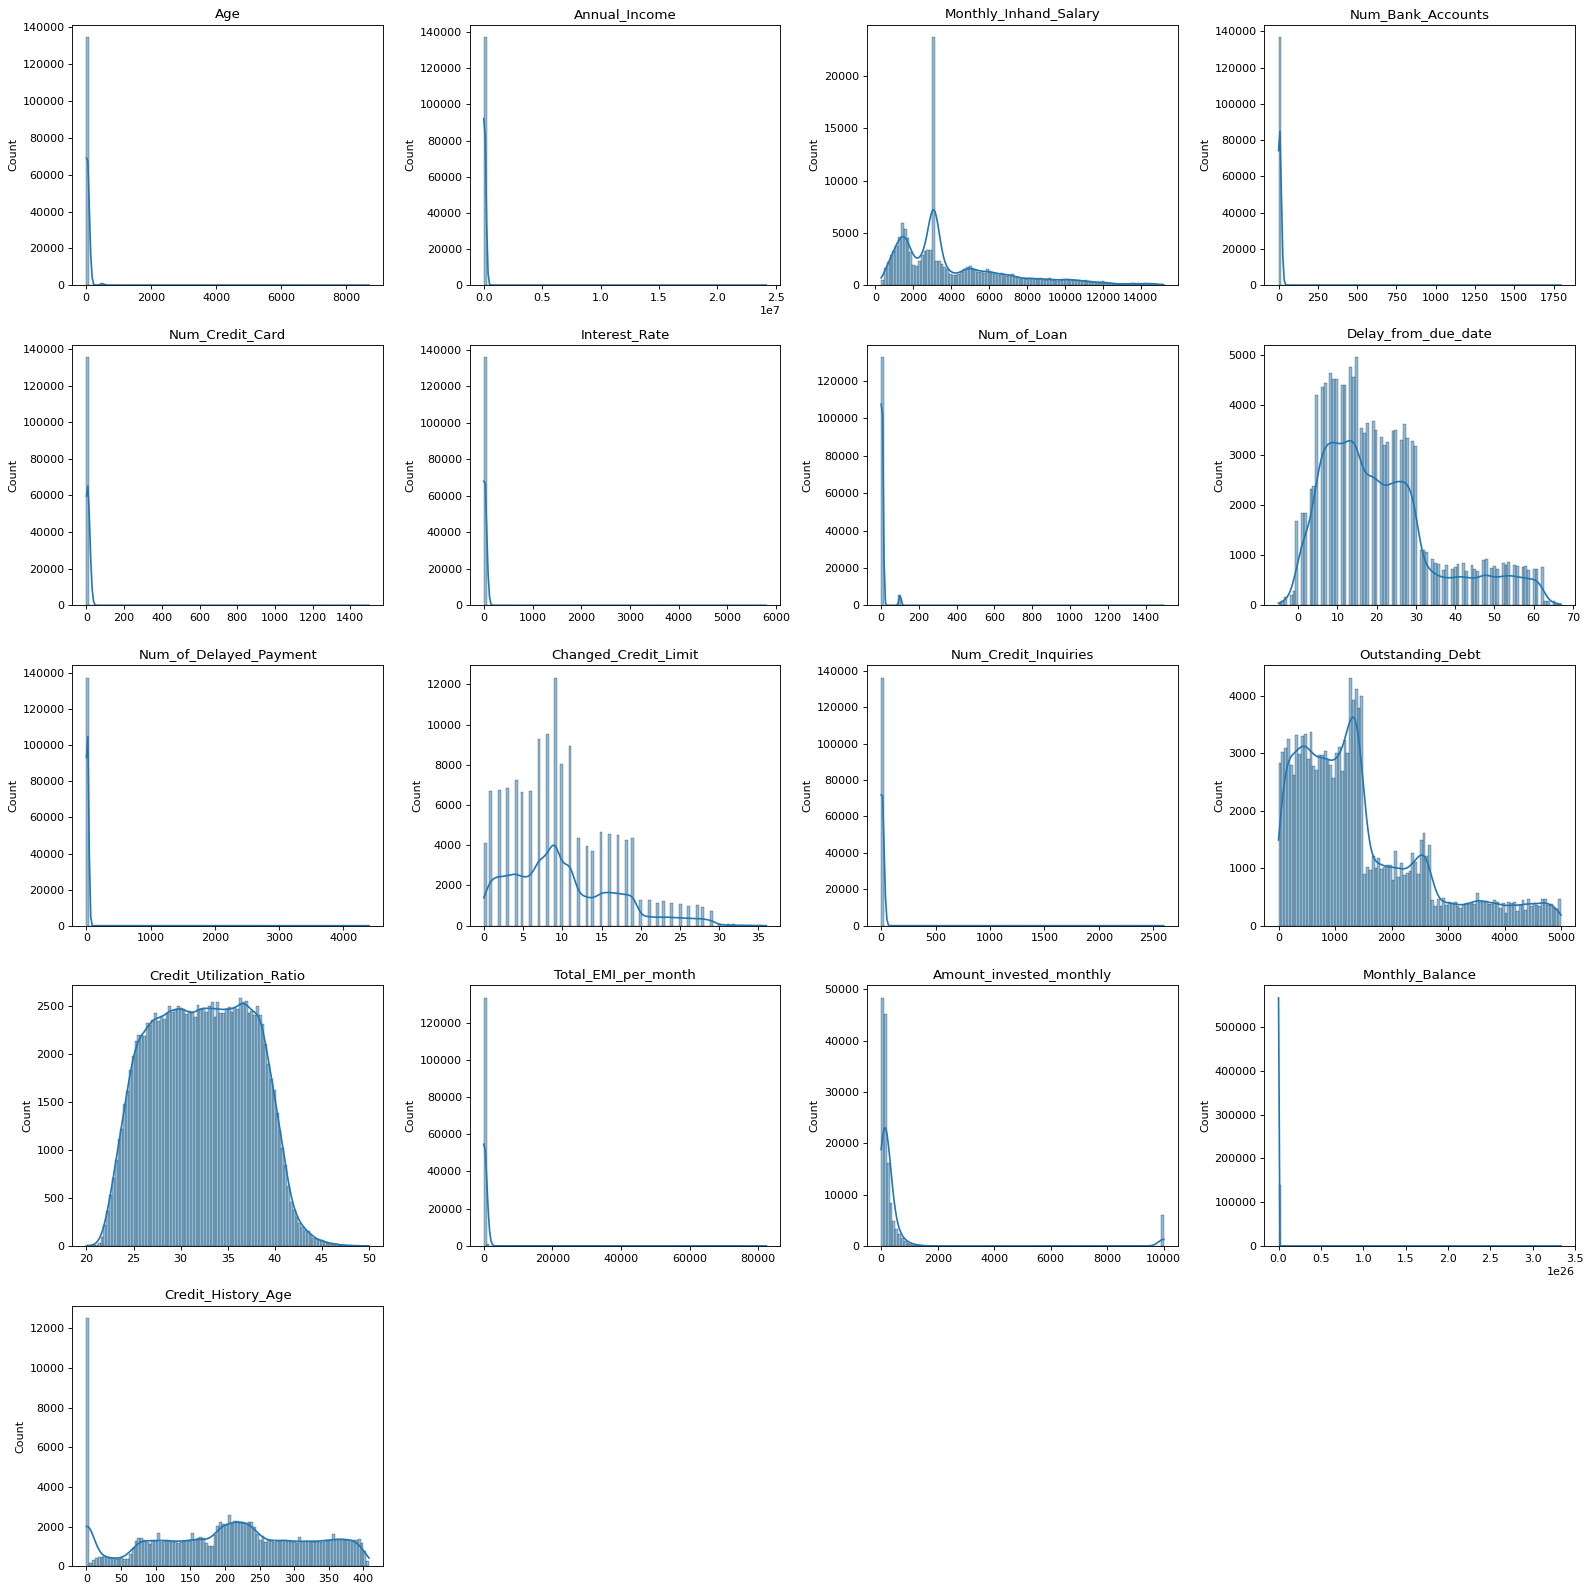

In [73]:
def plot_histograms(df, columns, rows=2, cols=3):

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten() 

    for i, col in enumerate(columns):
        if i < len(axes):  
            sns.histplot(df[col], kde=True, ax=axes[i], bins=100)
            axes[i].set_title(col)
            axes[i].set_xlabel('')  

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_histograms(df, num_cols, rows=5, cols=4)

In [74]:
df = df[df["Credit_History_Age"] != 0]

In [75]:
corr = df[num_cols].corr()

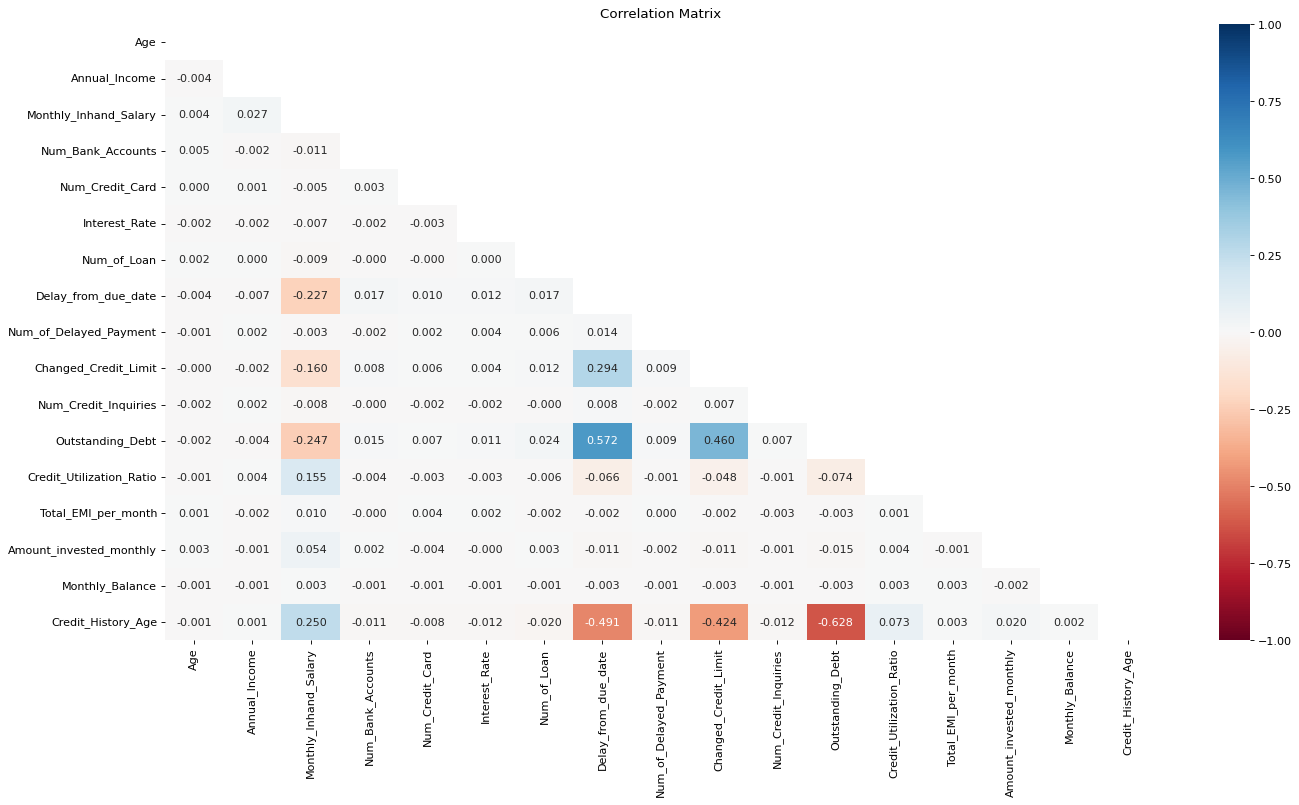

In [76]:
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 10))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt=".3f",
    annot_kws={'fontsize': 10},
    cmap="RdBu",
    vmin = -1,
    vmax = 1
)
plt.title("Correlation Matrix")
plt.show()

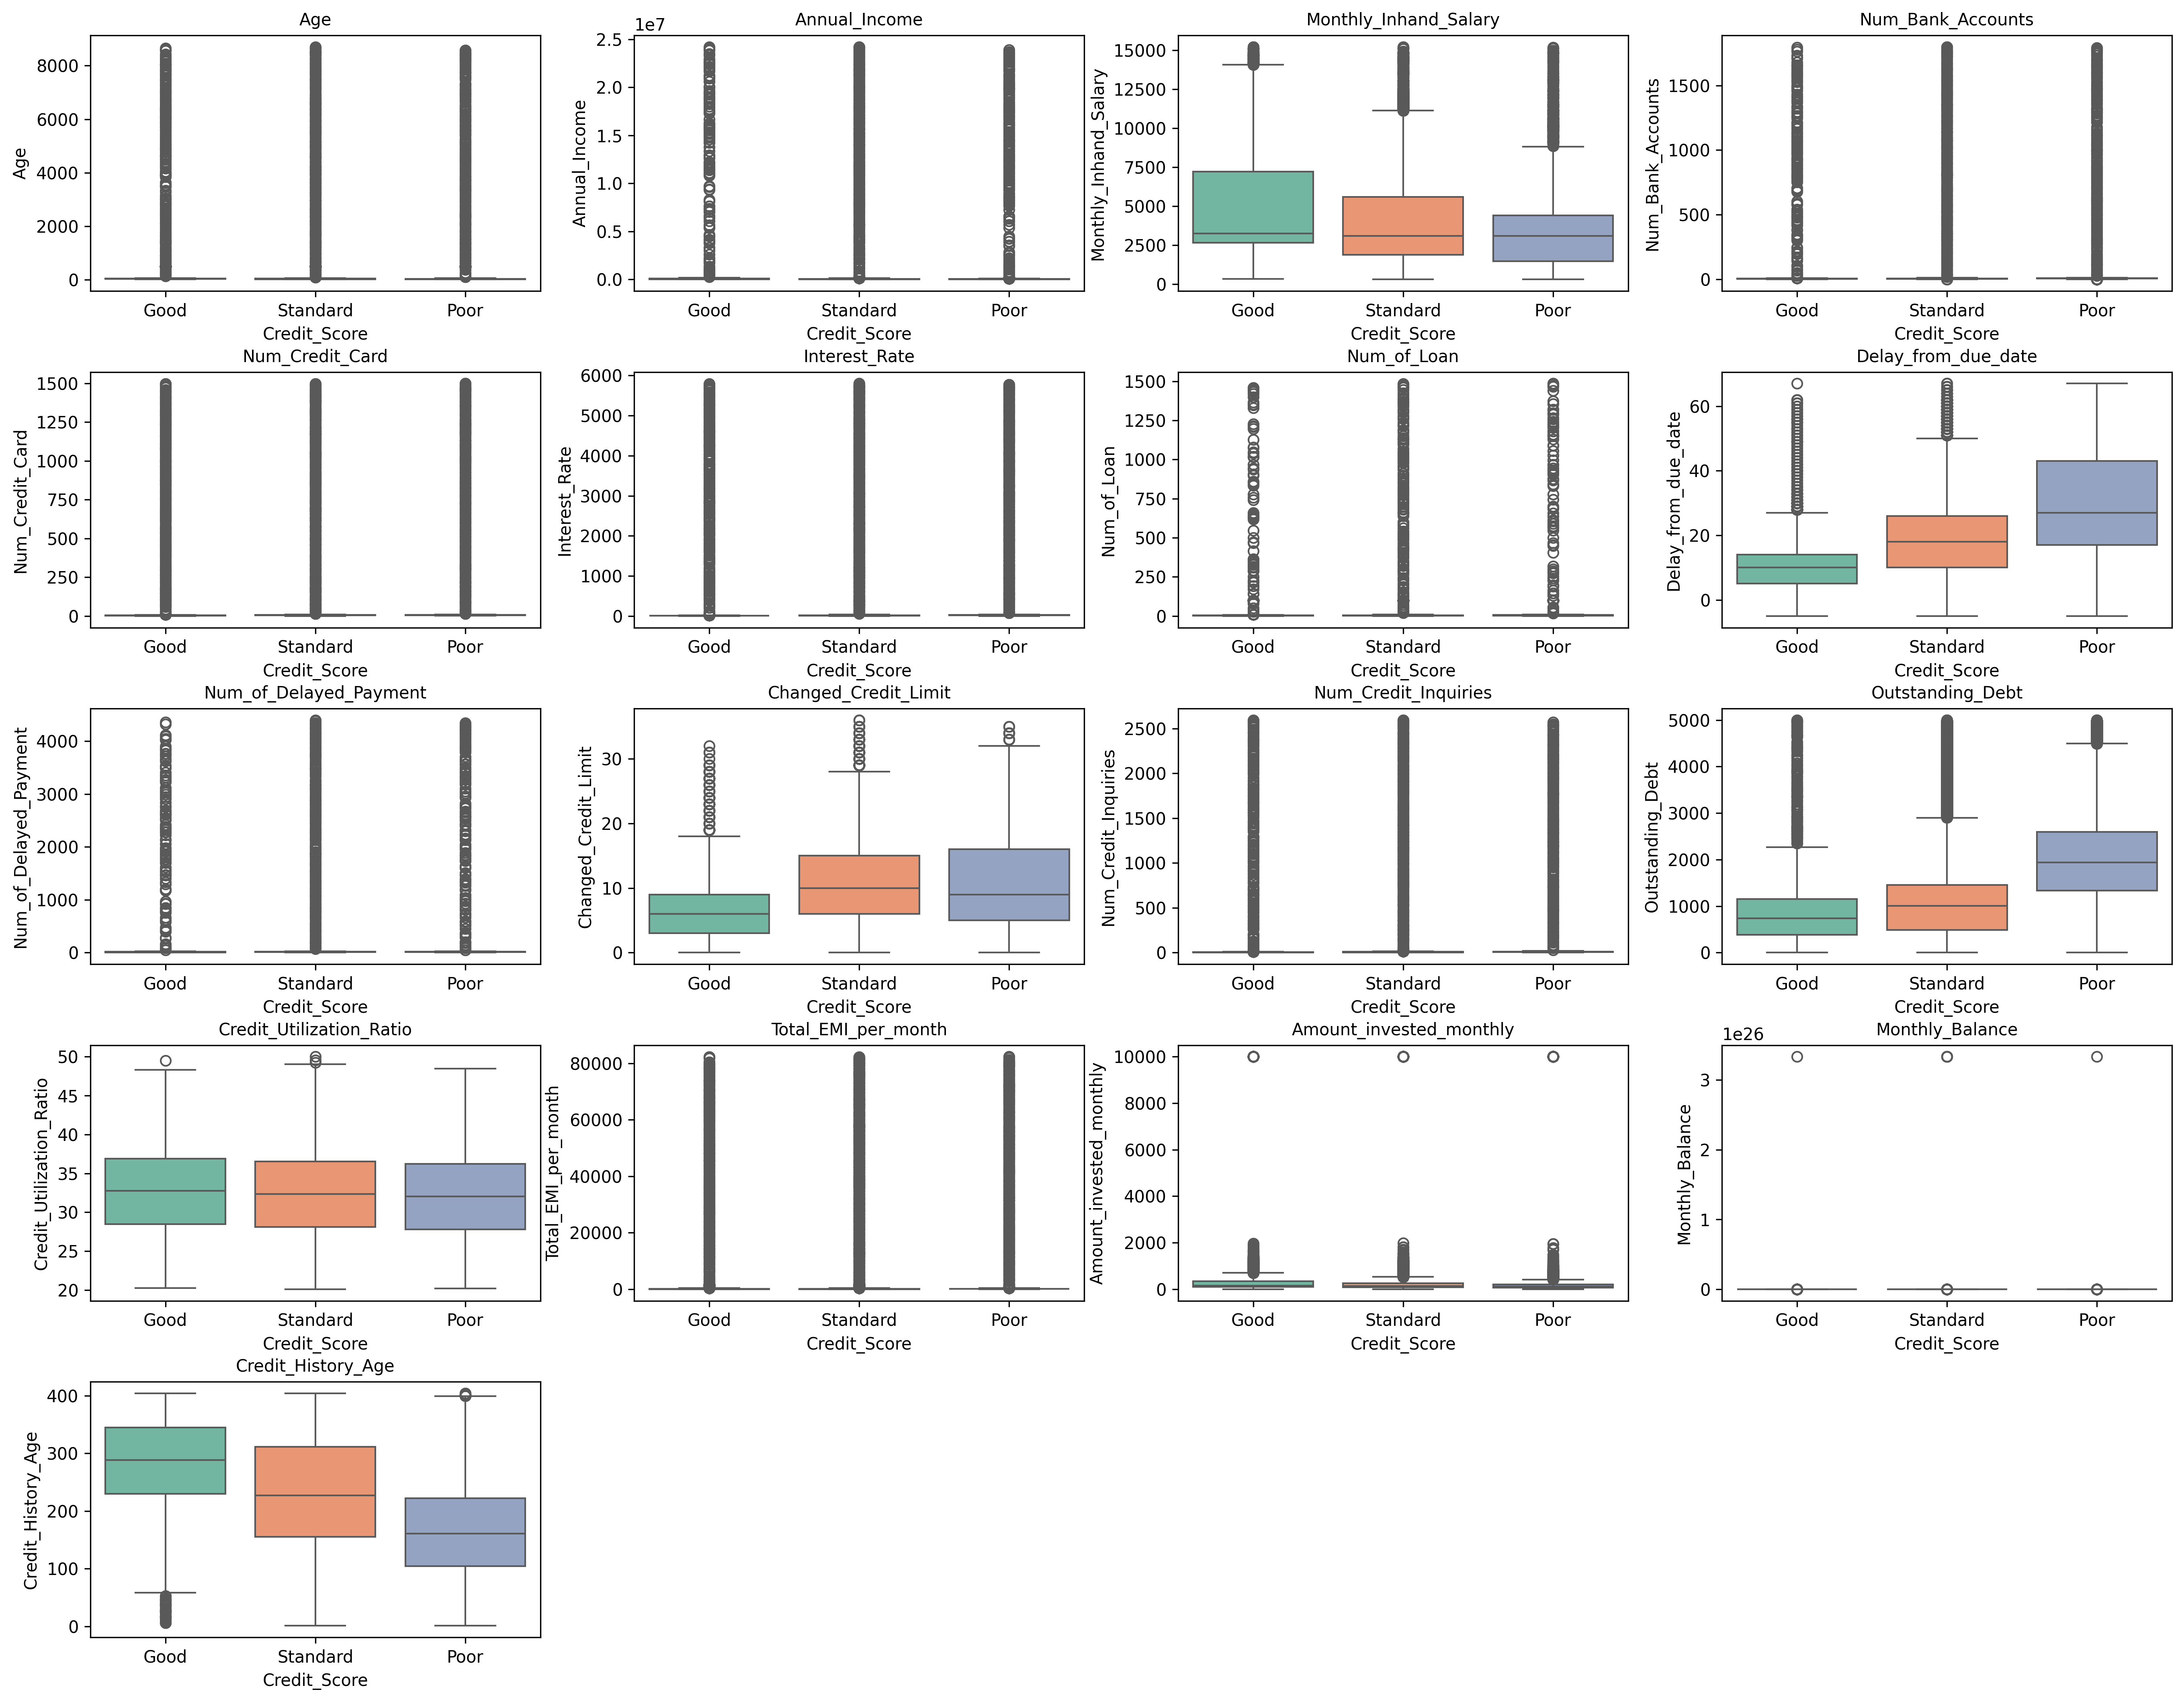

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def create_boxplots(dataframe, numeric_columns, target_column, figsize=(18, 14), dpi=300):

    df = dataframe.copy()
    df = df.reset_index(drop=True)
    
    n_cols = len(numeric_columns)
    n_rows = (n_cols + 3) // 4
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    matplotlib.rc(("xtick", "ytick", "text"), c="k")
    matplotlib.rc("figure", dpi=80)
    
    for idx, column in enumerate(numeric_columns, 1):
        ax = fig.add_subplot(n_rows, 4, idx)
        
        sns.boxplot(
            data=df,
            x=target_column,
            y=column,
            ax=ax,
            width=0.8,
            palette="Set2"
        )
        
        ax.set_title(column, fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        
    plt.tight_layout(pad=0.3)
    plt.show()
create_boxplots(df, num_cols, 'Credit_Score')

In [78]:
def analyze_categorical_columns(df, categorical_columns, plot=True):
    """
    Analyze categorical columns in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        categorical_columns (list): List of categorical column names.
        plot (bool, optional): Whether to display plots. Defaults to True.
    """

    for col in categorical_columns:
        print(f"\nAnalysis for column: {col}")
        print("##################################################")
        print(f"Unique values count: {df[col].nunique()}")
        print(f"Unique values: {df[col].unique()}")
        print(f"Value counts:\n{df[col].value_counts()}")

        if plot:
            plt.figure(figsize=(6, 3))
            # Using seaborn's countplot for better visualization
            ax = sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette="coolwarm")

            # Adding the count numbers on top of the bars
            for p in ax.patches:
                ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 5, p.get_y() + p.get_height() / 2),
                            ha='center', va='center')

            plt.title(f'{col} - Category Frequencies')
            plt.show()
        print("##################################################")

analyze_categorical_columns(df, cat_cols, False)


Analysis for column: Occupation
##################################################
Unique values count: 16
Unique values: ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']
Value counts:
Occupation
_______          8871
Lawyer           8273
Architect        8068
Mechanic         7984
Engineer         7977
Scientist        7944
Accountant       7933
Teacher          7907
Developer        7846
Entrepreneur     7843
Media_Manager    7796
Journalist       7687
Doctor           7650
Manager          7545
Musician         7462
Writer           7370
Name: count, dtype: int64
##################################################

Analysis for column: Credit_Mix
##################################################
Unique values count: 4
Unique values: ['_' 'Good' 'Standard' 'Bad']
Value counts:
Credit_Mix
Standard    46145
Good        30761
_           25261
Bad  

Occupation column removed 16667 rows.
Credit_Mix column removed 21943 rows.
Spending_Level column removed 0 rows.
Payment_Value column removed 0 rows.
Payment_of_Min_Amount column removed 0 rows.

Analysis for column: Occupation
##################################################
Unique values count: 14
Unique values: ['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician' 'Mechanic'
 'Writer' 'Architect']
Value counts:
Occupation
Lawyer          6626
Architect       6478
Accountant      6408
Mechanic        6391
Engineer        6376
Scientist       6346
Teacher         6274
Developer       6274
Entrepreneur    6245
Journalist      6184
Doctor          6113
Manager         5990
Musician        5969
Writer          5872
Name: count, dtype: int64


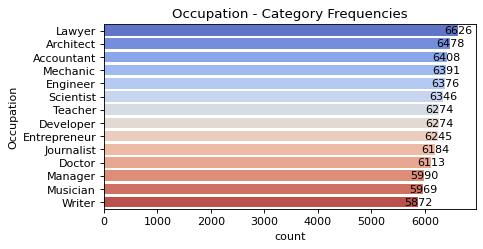

##################################################

Analysis for column: Credit_Mix
##################################################
Unique values count: 3
Unique values: ['Good' 'Standard' 'Bad']
Value counts:
Credit_Mix
Standard    39891
Good        26701
Bad         20954
Name: count, dtype: int64


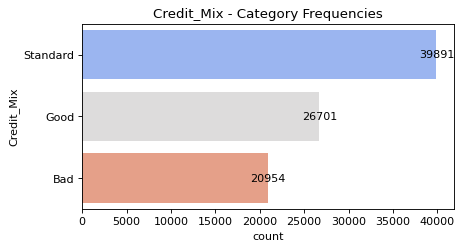

##################################################

Analysis for column: Spending_Level
##################################################
Unique values count: 2
Unique values: ['Low' 'High']
Value counts:
Spending_Level
Low     47047
High    40499
Name: count, dtype: int64


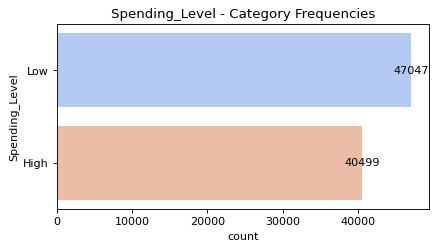

##################################################

Analysis for column: Payment_Value
##################################################
Unique values count: 3
Unique values: ['Medium' 'Small' 'Large']
Value counts:
Payment_Value
Small     34824
Medium    29819
Large     22903
Name: count, dtype: int64


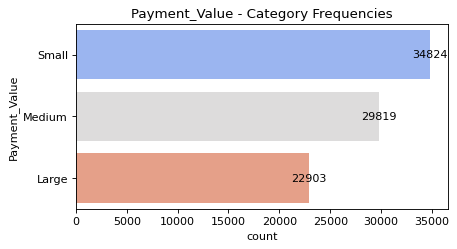

##################################################

Analysis for column: Payment_of_Min_Amount
##################################################
Unique values count: 3
Unique values: ['No' 'NM' 'Yes']
Value counts:
Payment_of_Min_Amount
Yes    45712
No     31310
NM     10524
Name: count, dtype: int64


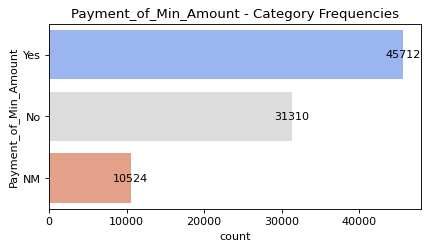

##################################################


In [79]:
def remove_underscore_rows(df, column_name):

    filtered_df = df[~df[column_name].str.contains('_', na=False)]
    
    removed_rows = len(df) - len(filtered_df)
    print(f"{column_name} column removed {removed_rows} rows.")
    
    return filtered_df

for col in cat_cols:
    df = remove_underscore_rows(df, col)  

analyze_categorical_columns(df, cat_cols, True)

In [80]:
replace = {"NM": "No"}
df["Payment_of_Min_Amount"] = df["Payment_of_Min_Amount"].replace(replace)

In [81]:
df["Payment_of_Min_Amount"].value_counts()

Payment_of_Min_Amount
Yes    45712
No     41834
Name: count, dtype: int64

**Feature Selection**
Hypothesis Testing with Chi-Square and F-Tests¶
<br> This Python code defines a chi_2_test function that conducts hypothesis testing to assess the relationship between categorical and numerical columns in a DataFrame and the target variable 'Credit_Score.'

- Function Purpose: The chi_2_test function first prepares a copy of the DataFrame with only training data and selects categorical and numerical columns of interest. It then initializes an empty NumPy array to store test results. The function performs two types of tests: Chi-Square tests for categorical columns and F-tests (ANOVA) for numerical columns to assess their significance in explaining 'Credit_Score' variations.

- Hypothesis Testing: The Chi-Square test evaluates the independence between categorical variables and 'Credit_Score,' while the F-tests assess the variance in 'Credit_Score' explained by numerical variables. The results include the test statistic and p-value for each column, helping identify significant factors influencing 'Credit_Score.'

<br> This function provides valuable insights into how different features relate to 'Credit_Score,' aiding in feature selection and understanding the dataset's predictive power in credit scoring analysis or modeling.

In [82]:
def chi_2_test(df: pd.DataFrame, cat_cols: list, num_cols: list):
    # Assuming that 'Credit_Score' and 'is_train' columns are in the DataFrame.
    df_copy = df.loc[df["is_train"]].copy()
    
    summary = np.empty((len(cat_cols) + len(num_cols), 3), dtype="object")
    y, *_ = df_copy["Credit_Score"].factorize(sort=False)

    def perform_test(cols, test):
        if test == "chi2":
            for i, col in enumerate(cols):
                cross = pd.crosstab(index=df_copy[col], columns=[df_copy["Credit_Score"]])
                t_stat, pvalue, *_ = chi2_contingency(cross)
                summary[i, :] = [col, t_stat, pvalue]

        elif test == "f_classif":
            for i, col in enumerate(cols, start=len(cat_cols)):
                t_stat, pvalue = f_classif(df_copy[[col]], y.reshape(-1, 1))
                summary[i, :] = [col, t_stat[0], pvalue[0]]

    # Perform Chi-square test for categorical columns
    perform_test(cat_cols, test="chi2")
    
    # Perform F-test for numerical columns
    perform_test(num_cols, test="f_classif")

    # Return results as a DataFrame
    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )

# Assuming cat_cols and num_cols are already defined
chi2_summary = chi_2_test(df, cat_cols, num_cols).sort_values(by="t-statistic", ascending=False)

In [83]:
chi2_summary.style.bar("t-statistic").background_gradient("Blues", subset="t-statistic")

,column,t-statistic,p-value
1,Credit_Mix,23652.236393,0.000000
4,Payment_of_Min_Amount,9901.154879,0.000000
12,Delay_from_due_date,6801.952739,0.000000
16,Outstanding_Debt,5361.712449,0.000000
21,Credit_History_Age,5230.992323,0.000000
14,Changed_Credit_Limit,1516.385098,0.000000
7,Monthly_Inhand_Salary,1076.659358,0.000000
2,Spending_Level,542.986279,0.000000
3,Payment_Value,492.308246,0.000000
0,Occupation,137.132646,0.000000


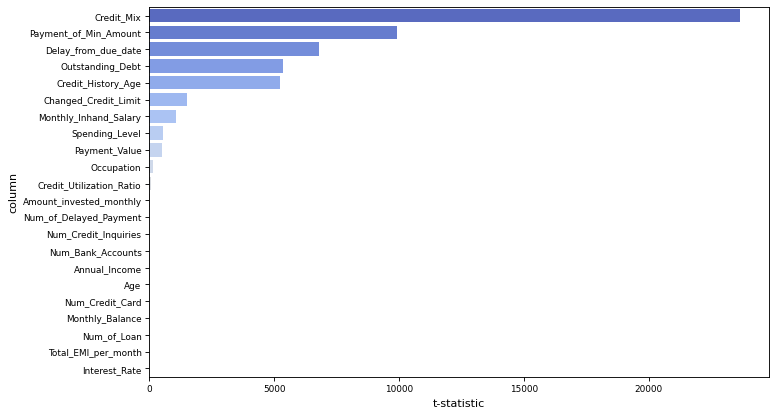

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=chi2_summary, y="column", x="t-statistic", palette="coolwarm", ax=ax)
plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], size=8)
fig.show()

In [85]:
insignificant_columns = [
    'Annual_Income', 'Age', 'Num_Credit_Card', 'Monthly_Balance', 'Num_of_Loan', 'Total_EMI_per_month', 'Interest_Rate'
]
df = df.drop(columns=insignificant_columns)

In [86]:
df[df["is_train"] == False]["Credit_Score"].isna().sum()

df[df["is_train"] == True]["Credit_Score"].isna().sum()

np.int64(0)

In [87]:
df[df["is_train"] == True]["Credit_Score"].value_counts()

Credit_Score
Standard    30805
Poor        16943
Good        10377
Name: count, dtype: int64

In [88]:
df.to_csv('clean_data.csv', index=False)
df = pd.read_csv('clean_data.csv')

In [89]:
train_data = df[df['is_train'] == True].drop(columns=['is_train'])
test_data = df[df['is_train'] == False].drop(columns=['is_train'])

X = train_data.drop(columns=['Credit_Score'])
y = train_data['Credit_Score']
X_test = test_data.drop(columns=['Credit_Score'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [91]:
for index, class_name in enumerate(label_encoder.classes_):
    print(f"Class '{class_name}' is encoded as {index}")

Class 'Good' is encoded as 0
Class 'Poor' is encoded as 1
Class 'Standard' is encoded as 2


In [92]:
df["Credit_Score"].value_counts()

Credit_Score
Standard    30805
Poor        16943
Good        10377
Name: count, dtype: int64

In [93]:
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
one_hot_cols = ["Occupation", "Payment_of_Min_Amount"]
ordinal_cols = ["Credit_Mix", "Spending_Level", "Payment_Value"]

ordinal_categories = [
    ['Bad', 'Standard', 'Good'],  
    ['Low', 'High'],    
    ['Small', 'Medium', 'Large']
]

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),  
        ('one_hot_enc', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),  
        ('ordinal_enc', OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols)
    ]
)

In [95]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [96]:
from collections import Counter
print("Before:", Counter(y_train_encoded))
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("After:", Counter(y_train_resampled))

Before: Counter({np.int64(2): 24644, np.int64(1): 13554, np.int64(0): 8302})
After: Counter({np.int64(2): 24644, np.int64(1): 24644, np.int64(0): 24644})


In [97]:
from tensorflow.keras.layers import BatchNormalization

In [98]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)
    
    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [99]:
model = Sequential([
    Dense(512, activation='relu'),
    BatchNormalization(),


    Dense(512, activation='relu'),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),

    
    Dense(256, activation='relu'),
    BatchNormalization(),

    
    Dense(128, activation='relu'),
    BatchNormalization(),

    
    Dense(64, activation='relu'),
    BatchNormalization(),

    
    Dense(64, activation='relu'),
    BatchNormalization(),


    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(3, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=35,
                               restore_best_weights=True)


history = model.fit(x=X_train_resampled,
                    y=y_train_resampled,
                    validation_data=(X_val, y_val_encoded),
                    validation_split=0.2,
                    batch_size=512,
                    epochs=600,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6408 - loss: 0.8740 - val_accuracy: 0.5702 - val_loss: 0.8521
Epoch 2/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7078 - loss: 0.7141 - val_accuracy: 0.6181 - val_loss: 0.8380
Epoch 3/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7152 - loss: 0.6967 - val_accuracy: 0.6474 - val_loss: 0.7829
Epoch 4/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7223 - loss: 0.6701 - val_accuracy: 0.6541 - val_loss: 0.7817
Epoch 5/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7310 - loss: 0.6545 - val_accuracy: 0.6529 - val_loss: 0.7774
Epoch 6/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7378 - loss: 0.6346 - val_accuracy: 0.6583 - val_loss: 0.7662
Epoch 7/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7465 - loss: 0.6100 - val_accuracy: 0.6535 - val_loss: 0.7938
Epoch 8/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7535 - loss: 0.5968 - 

In [100]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,582,475 (6.04 MB)

 Trainable params: 526,275 (2.01 MB)

 Non-trainable params: 3,648 (14.25 KB)

 Optimizer params: 1,052,552 (4.02 MB)

In [101]:
eval_metric(model, X_train_resampled, y_train_resampled, X_val, y_val_encoded)

2311/2311 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Set:
[[1198  147  730]
 [ 183 2374  832]
 [ 728 1096 4337]]
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      2075
           1       0.66      0.70      0.68      3389
           2       0.74      0.70      0.72      6161

    accuracy                           0.68     11625
   macro avg       0.65      0.66      0.66     11625
weighted avg       0.68      0.68      0.68     11625


Train Set:
[[24064    74   506]
 [  351 23815   478]
 [  619   826 23199]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     24644
           1       0.96      0.97      0.96     24644
           2       0.96      0.94      0.95     24644

    accuracy                           0.96     73932
   macro avg       0.96      0.96      0.96     73932
weighted avg       0.96      0.96      0.96     73932



In [102]:
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
num_cols.remove("is_train")

def outlier_ratio(dataframe, column):
    lower_bound, upper_bound = outlier_bounds(dataframe, column)
    train_mask = dataframe["is_train"] == True
    total_count = dataframe[train_mask].shape[0]
    outlier_count = dataframe[(train_mask) & 
                              ((dataframe[column] < lower_bound) | (dataframe[column] > upper_bound))].shape[0]
    
    return (outlier_count / total_count) * 100 if total_count > 0 else 0

def outlier_bounds(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


def remove_outliers(dataframe, column):
    lower_bound, upper_bound = outlier_bounds(dataframe, column)
    train_mask = dataframe["is_train"] == True
    outlier_indices = dataframe[(train_mask) & 
                                ((dataframe[column] < lower_bound) | (dataframe[column] > upper_bound))].index
    dataframe.drop(outlier_indices, inplace=True)


for col in num_cols:
    remove_outliers(df, col)
    ratio = outlier_ratio(df[df["is_train"] == True], col)  
    print(f"{col} : %{ratio}")

Monthly_Inhand_Salary : %2.6158136187820458
Num_Bank_Accounts : %0.02551299340306885
Delay_from_due_date : %1.9061025719068634
Num_of_Delayed_Payment : %0.0
Changed_Credit_Limit : %0.0
Num_Credit_Inquiries : %0.632523571386215
Outstanding_Debt : %3.679919938285762
Credit_Utilization_Ratio : %0.0
Credit_History_Age : %0.0
Amount_invested_monthly : %5.168210628961482


In [103]:
df.to_csv("without_outliers.csv", index=False)
df = pd.read_csv("without_outliers.csv")

In [104]:
df[df['is_train'] == True]['Credit_Score'].value_counts()

Credit_Score
Standard    23342
Poor        11980
Good         7749
Name: count, dtype: int64

In [105]:
train_data = df[df['is_train'] == True].drop(columns=['is_train'])
test_data = df[df['is_train'] == False].drop(columns=['is_train'])

X = train_data.drop(columns=['Credit_Score'])
y = train_data['Credit_Score']
X_test = test_data.drop(columns=['Credit_Score'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val) 

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
one_hot_cols = ["Occupation", "Payment_of_Min_Amount"]
ordinal_cols = ["Credit_Mix", "Spending_Level", "Payment_Value"]

ordinal_categories = [
    ['Bad', 'Standard', 'Good'],  
    ['Low', 'High'],    
    ['Small', 'Medium', 'Large']
] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),  
        ('one_hot_enc', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),  
        ('ordinal_enc', OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols)
    ]
) 

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [106]:
unique_classes = np.unique(y_train)
class_weight_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)
class_weight_dict = {int(i): float(w) for i, w in zip(unique_classes, class_weight_array)}
print("Class weights:", class_weight_dict)


model = Sequential([
    Input(shape=(X_train.shape[1],)),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(3, activation='softmax')
]) 


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping], 
    class_weight=class_weight_dict
)

Class weights: {0: 1.8527719524654513, 1: 1.1983861992209237, 2: 0.6150770274371196}
Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5681 - loss: 1.0587 - val_accuracy: 0.2781 - val_loss: 1.1900
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6538 - loss: 0.7927 - val_accuracy: 0.3394 - val_loss: 1.0206
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6636 - loss: 0.7717 - val_accuracy: 0.6559 - val_loss: 0.8532
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6767 - loss: 0.7432 - val_accuracy: 0.6843 - val_loss: 0.7880
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6813 - loss: 0.7307 - val_accuracy: 0.6850 - val_loss: 0.7878
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6811 - loss: 0.7211 - val_accuracy: 0.6832 - val_loss: 0.7812
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6807 - loss: 0.7207 - val_accuracy: 0.6910 - val_loss: 0.7546
Epoch 8/100


In [107]:
eval_metric(model, X_train,y_train, X_val,  y_val)

1077/1077 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
Test Set:
[[1290   30  230]
 [ 346 1640  410]
 [ 928  646 3095]]
              precision    recall  f1-score   support

           0       0.50      0.83      0.63      1550
           1       0.71      0.68      0.70      2396
           2       0.83      0.66      0.74      4669

    accuracy                           0.70      8615
   macro avg       0.68      0.73      0.69      8615
weighted avg       0.74      0.70      0.71      8615


Train Set:
[[ 5283    80   836]
 [ 1353  6719  1512]
 [ 3740  2668 12265]]
              precision    recall  f1-score   support

           0       0.51      0.85      0.64      6199
           1       0.71      0.70      0.71      9584
           2       0.84      0.66      0.74     18673

    accuracy                           0.70     34456
   macro avg       0.69      0.74      0.69     34456
weighted avg       0.74      0.70      0.71     34456



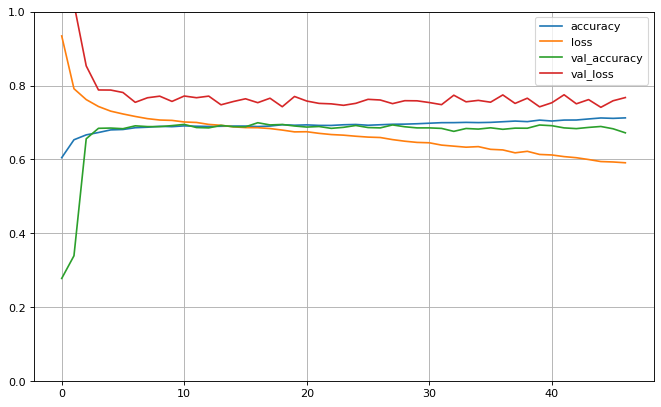

In [108]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()